# Scorecards and Ensembles

In this lab we will focus on developing a scorecard using our WoE-trained dataset, and will compare it with a Random Forest created over the original data. For this, we will first import the data and re-train our original logistic regression.



## Imports and preparation

In [158]:
pip install scorecardpy

Note: you may need to restart the kernel to use updated packages.


In [159]:
import pandas as pd
import scorecardpy as sc
import numpy as np
import sklearn

In [160]:
# Import the files as Pandas datasets
bankloan_train_WoE = pd.read_csv('train_woe.csv')
bankloan_test_WoE = pd.read_csv('test_woe.csv')
bankloan_data = pd.read_csv('Credit data.csv')
bankloan_train_noWoE = pd.read_csv('bankloan_train_noWoE.csv')
bankloan_test_noWoE = pd.read_csv('bankloan_test_noWoE.csv')


# add new column

#bankloan_data.insert(0, 'ID', range(1, len(bankloan_data) + 1))

# Move 'SeriousDlqin2yrs' column to the last position
#column_to_move = 'SeriousDlqin2yrs'
#columns = [col for col in bankloan_data.columns if col != column_to_move]  # Exclude SeriousDlqin2yrs
#columns.append(column_to_move)  # Append it at the end

# Reorder DataFrame
#bankloan_data = bankloan_data[columns]

# Change SeriousDlqin2yrs into Default
#bankloan_data = bankloan_data.rename(columns={'SeriousDlqin2yrs': 'Default'})

# Eliminate unused variables
#bankloan_data = bankloan_data.drop(columns=['NumberOfDependents'])

# Replace missing values
#def replace_missing_values(df):
#    for column in df.columns:
 #       if df[column].dtype in ['int64', 'float64']:  # Continuous (numerical) variables
  #          median_value = df[column].median()
   #         df[column].fillna(median_value, inplace=True)
    #    else:  # Categorical variables
     #       mode_value = df[column].mode()[0]
      #      df[column].fillna(mode_value, inplace=True)
    #return df

#bankloan_data = replace_missing_values(bankloan_data)


In [161]:


# Give breaks for noWoE
breaks_adj = {
    # Below are the intervals for different bins
#          "DebtRatio": [0.3, 0.45, 0.8, 2.55], "NumberOfOpenCreditLinesAndLoans": [6.0],
 #       'NumberRealEstateLoansOrLines': [1, 2],	'RevolvingUtilizationOfUnsecuredLines':[0.55],
  #  "MonthlyIncome": [1000, 5000.0, 7000.0], 'NumberOfTime30-59DaysPastDueNotWorse':[1]
}
# Apply breaks.
bins_adj = sc.woebin(bankloan_train_noWoE, y="Default", breaks_list=breaks_adj)

[INFO] creating woe binning ...


c:\Users\leduc\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\leduc\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\leduc\anaconda3\Lib\site-packages\scorecardpy\woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

Find the best parameter for Logistic Regression using GridSearchCV

In [162]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
# Define the features (X) and target (y)
X = bankloan_train_WoE.iloc[:, 1:]  # Select all rows and columns from the second onward
y = bankloan_train_WoE['Default']  # Target column
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],          # Test different regularization strengths
    'penalty': ['l1', 'l2'],          # Test L1 (lasso) and L2 (ridge) regularization
    'solver': ['liblinear', 'saga'],  # Solvers compatible with L1 and L2
    'class_weight': [None, 'balanced']  # Test handling class imbalance
}

# Define the model
bankloan_logreg = LogisticRegression(
    tol=0.0001,                 # Tolerance for convergence
    fit_intercept=True,         # Whether to include the intercept
    random_state=36621943,      # Seed for reproducibility
    max_iter=300,               # Maximum number of iterations
    verbose=1                   # Display training information
)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=bankloan_logreg,
    param_grid=param_grid,
    scoring='roc_auc',          # Use accuracy as the evaluation metric
    cv=5,                        # 5-Fold cross-validation
    verbose=1,                   # Display progress
    n_jobs=-1                    # Use all available CPU cores
)

# Perform Grid Search
grid_search.fit(X, y)

# Display the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Best ROC-AUC Score: {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
convergence after 17 epochs took 0 seconds
Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.8580168542371256
Best ROC-AUC Score: 0.858


Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best ROC-AUC score: 0.8580168542371256

Find the best parameter for random forest using GridSearchCV

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500],          # Number of trees
    'max_depth': [10, 20, 30],               # Maximum depth of trees
    'min_samples_split': [2, 5],               # Minimum samples to split a node
    'min_samples_leaf': [ 2, 4],                 # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2'],        # Number of features to consider at each split
    #'bootstrap': [True],                    # Whether to use bootstrap samples
   # 'class_weight': ['balanced']  # Handle class imbalance
}

# Create a RandomForestClassifier
bankloan_rf = RandomForestClassifier(
                      #  n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       #max_depth=None, # Max depth of the trees. Not necessary to change.
                       #min_samples_split=2, # Minimum samples to create a split.
                       #min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       #max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=36621943, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    )

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=bankloan_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',       # Use ROC-AUC as the scoring metric
    cv=5,                    # 5-Fold cross-validation
    verbose=1,               # Display progress during training
    n_jobs=-1                # Use all available CPU cores
)

# Perform Grid Search
grid_search_rf.fit(bankloan_train_noWoE.iloc[:,:-1], bankloan_train_noWoE['Default'])

# Display the best parameters and best score
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)
print(f"Best ROC-AUC Score: {grid_search_rf.best_score_:.3f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s


Best Parameters for Random Forest:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC-AUC Score: 0.940


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished


Best Parameters for Random Forest:
{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC-AUC Score: 0.970

***Now when we have the best parameter for both models, time to evaluate with different thresholds***

In [164]:
# Retrieve the best estimator from GridSearchCV logistic
best_model_lr = grid_search.best_estimator_
# Retrieve the best estimator from GridSearchCV random forest
best_model_rf = grid_search_rf.best_estimator_

In [165]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = np.linspace(0, 1, 100)
def evaluate_model(model, X_test, y_true, threshold):
    """Evaluates a model at a specific threshold.
    
    Args:
        model: The trained model.
        X_test: The test data.
        y_true: The true labels for the test data.
        threshold: The threshold to use for classification.
    
    Returns:
        A dictionary containing the evaluation metrics.
    """

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)  # Calculate AUC using probabilities
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc}

In [166]:
# Assuming you have your trained models as bankloan_logreg and bankloan_rf,
# and your test data as X_test and y_test
models = {'Logistic Regression': best_model_lr, 'Random Forest': best_model_rf}

all_results = []  # List to store results for all models and thresholds

for model_name, model in models.items():
    for threshold in thresholds:
        # Use the appropriate test set based on the model
        if model_name == 'Logistic Regression':
            X_test = bankloan_test_WoE.iloc[:, 1:] # Apply on test set
            y_true = bankloan_test_WoE['Default']
        else:  # model_name == 'Random Forest'
            X_test = bankloan_test_noWoE.iloc[:, :-1]  # Exclude the target column Apply on test set without WoE
            y_true = bankloan_test_noWoE['Default']
            
        results = evaluate_model(model, X_test, y_true, threshold)
        results['Model'] = model_name
        results['Threshold'] = threshold
        all_results.append(results)

# Create DataFrame from results
results_df = pd.DataFrame(all_results)

# Display the DataFrame
results_df

c:\Users\leduc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend Thread

,Accuracy,Precision,Recall,F1-Score,AUC,Model,Threshold
0,0.063465,0.063465,1.0,0.119355,0.825600,Logistic Regression,0.000000
1,0.063465,0.063465,1.0,0.119355,0.825600,Logistic Regression,0.010101
2,0.070326,0.063903,1.0,0.120130,0.825600,Logistic Regression,0.020202
3,0.095712,0.065580,1.0,0.123087,0.825600,Logistic Regression,0.030303
4,0.138593,0.068620,1.0,0.128428,0.825600,Logistic Regression,0.040404
...,...,...,...,...,...,...,...
195,0.936535,0.000000,0.0,0.000000,0.814441,Random Forest,0.959596
196,0.936535,0.000000,0.0,0.000000,0.814441,Random Forest,0.969697
197,0.936535,0.000000,0.0,0.000000,0.814441,Random Forest,0.979798
198,0.936535,0.000000,0.0,0.000000,0.814441,Random Forest,0.989899


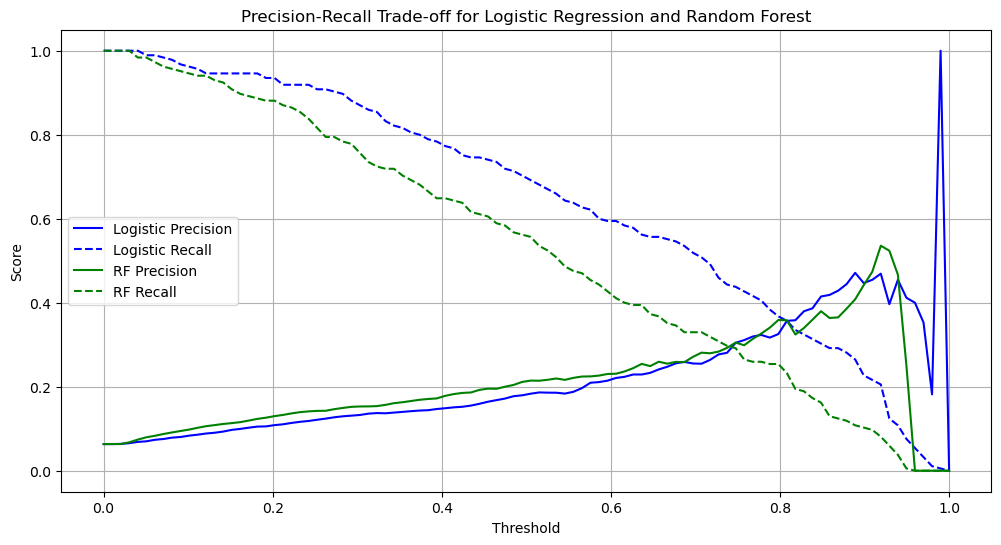

In [167]:
# Separate Precision and Recall for Logistic Regression and Random Forest
logistic_results = results_df[results_df['Model'] == 'Logistic Regression']
rf_results = results_df[results_df['Model'] == 'Random Forest']

# Plot precision-recall trade-off for Logistic Regression
plt.figure(figsize=(12, 6))
plt.plot(logistic_results['Threshold'], logistic_results['Precision'], label='Logistic Precision', color='blue')
plt.plot(logistic_results['Threshold'], logistic_results['Recall'], label='Logistic Recall', linestyle='--', color='blue')

# Plot precision-recall trade-off for Random Forest
plt.plot(rf_results['Threshold'], rf_results['Precision'], label='RF Precision', color='green')
plt.plot(rf_results['Threshold'], rf_results['Recall'], label='RF Recall', linestyle='--', color='green')

# Add labels, legend, and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off for Logistic Regression and Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()

Choose the threshold with the highest F1-score, which balances precision and recall.
This is useful if you care equally about precision and recall.

From your data:

For Logistic Regression: Threshold 0.6 (F1-Score = 0.301480)

For Random Forest: Threshold 0.4 (F1-Score = 0.327718)

In [168]:
import pandas as pd

# Retrieve the best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Get the coefficients and intercept
coefficients = best_model.coef_.flatten()  # Flatten to make it 1D
intercept = best_model.intercept_[0]  # Intercept term

# Get the feature names
feature_names = X.columns  # Assuming X is a DataFrame

# Combine feature names with coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Display the results
print("Feature Coefficients:")
print(coeff_df)

print("\nIntercept (bias term):")
print(intercept)



Feature Coefficients:
                                    Feature  Coefficient
0               NumberOfTimes90DaysLate_woe     0.575322
1       NumberOfOpenCreditLinesAndLoans_woe     0.160678
2  RevolvingUtilizationOfUnsecuredLines_woe     0.693046
3          NumberRealEstateLoansOrLines_woe     1.050196
4  NumberOfTime30-59DaysPastDueNotWorse_woe     0.390154
5                    NumberOfDependents_woe     1.095731
6  NumberOfTime60-89DaysPastDueNotWorse_woe     0.325887
7                                   age_woe     0.716309
8                             DebtRatio_woe     1.242340
9                         MonthlyIncome_woe    -0.092227

Intercept (bias term):
0.0009355167780625216


In [169]:
bankloan_logreg = best_model_lr

coef_df = pd.concat([pd.DataFrame({'Feature': bankloan_train_WoE.columns[1:]}),
                    pd.DataFrame(np.transpose(bankloan_logreg.coef_))],
                    axis = 1
                   )

coef_df
# Renaming the column 0 to 'Coefficient'
coef_df.rename(columns={0: 'Coefficient'}, inplace=True)
coef_df

,Feature,Coefficient
0,NumberOfTimes90DaysLate_woe,0.575322
1,NumberOfOpenCreditLinesAndLoans_woe,0.160678
2,RevolvingUtilizationOfUnsecuredLines_woe,0.693046
3,NumberRealEstateLoansOrLines_woe,1.050196
4,NumberOfTime30-59DaysPastDueNotWorse_woe,0.390154
5,NumberOfDependents_woe,1.095731
6,NumberOfTime60-89DaysPastDueNotWorse_woe,0.325887
7,age_woe,0.716309
8,DebtRatio_woe,1.242340
9,MonthlyIncome_woe,-0.092227


In [170]:
bankloan_logreg.intercept_

array([0.00093552])

                                    Feature  Importance
8                             DebtRatio_woe    1.242340
5                    NumberOfDependents_woe    1.095731
3          NumberRealEstateLoansOrLines_woe    1.050196
7                                   age_woe    0.716309
2  RevolvingUtilizationOfUnsecuredLines_woe    0.693046
0               NumberOfTimes90DaysLate_woe    0.575322
4  NumberOfTime30-59DaysPastDueNotWorse_woe    0.390154
6  NumberOfTime60-89DaysPastDueNotWorse_woe    0.325887
1       NumberOfOpenCreditLinesAndLoans_woe    0.160678
9                         MonthlyIncome_woe   -0.092227


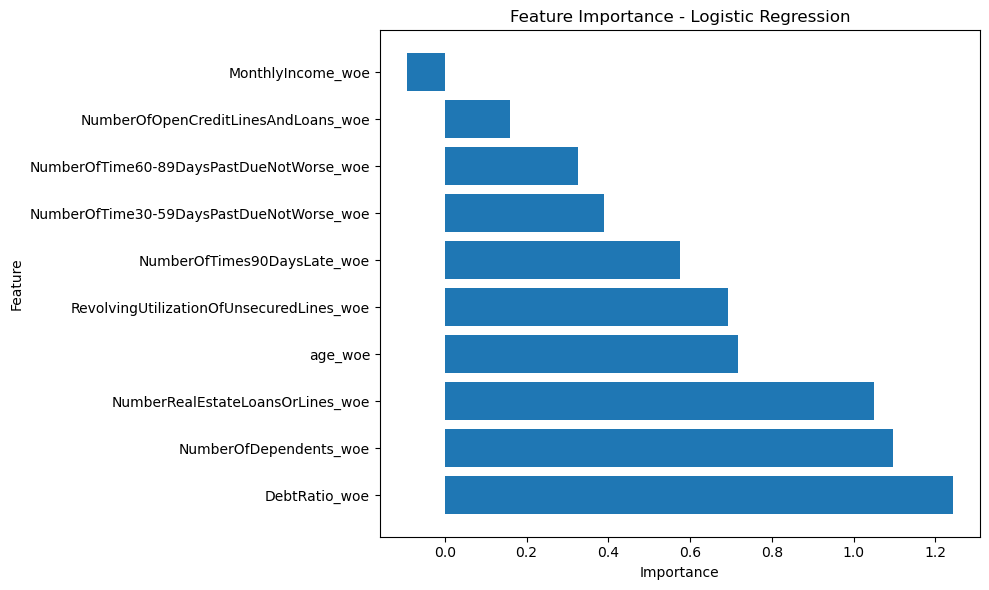

In [171]:
import pandas as pd

# Get feature names and coefficients
feature_names = bankloan_train_WoE.columns[1:]
coefficients = bankloan_logreg.coef_[0]

# Create DataFrame
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)

# Display the feature importance
print(feature_importance)

import matplotlib.pyplot as plt

# Create horizontal bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(feature_importance['Feature'], feature_importance['Importance'])

# Customize plot
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

**Model performance**

In [172]:
pred_class_test = bankloan_logreg.predict(bankloan_test_WoE.iloc[:, 1:])
probs_test = bankloan_logreg.predict_proba(bankloan_test_WoE.iloc[:, 1:])
print(probs_test, pred_class_test)

[[0.27815189 0.72184811]
 [0.52464702 0.47535298]
 [0.64538091 0.35461909]
 ...
 [0.25807721 0.74192279]
 [0.25807721 0.74192279]
 [0.96571731 0.03428269]] [1 0 0 ... 1 1 0]


In [173]:
# Define the true labels and predicted probabilities
y_true = bankloan_test_WoE['Default']  # Replace with your test target variable
y_proba = probs_test[:, 1]             # Predicted probabilities for the positive class - Default

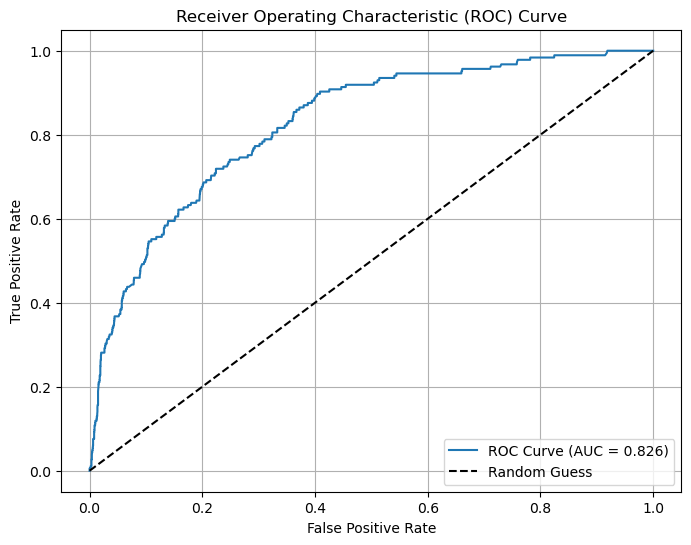

In [174]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Calculate the AUC
auc = roc_auc_score(y_true, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

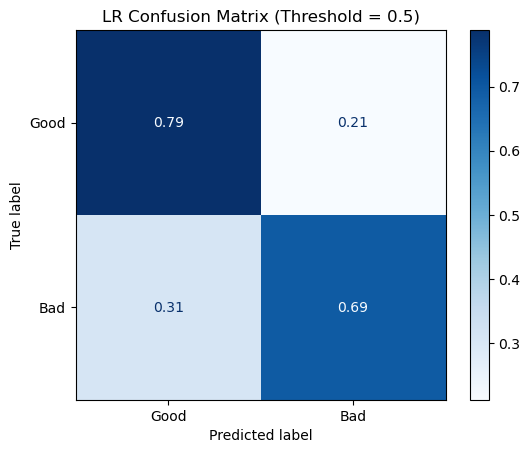

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply the threshold of 0.4 to the predicted probabilities
y_pred = (y_proba >= 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix to show ratios
cm_ratios = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ratios, display_labels=['Good', 'Bad'])
disp.plot(cmap='Blues', values_format=".2f")
plt.title(f'LR Confusion Matrix (Threshold = 0.5)')
plt.show()



In [176]:
# Apply the threshold of 0.6 to the predicted probabilities
y_pred = (y_proba >= 0.5).astype(int)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=["Non-Default", "Default"], output_dict=True)

# Convert the report to a DataFrame for better display
import pandas as pd
classification_report_df = pd.DataFrame(report).transpose()

# Display the classification report
print("\nClassification Report:")
classification_report_df


Classification Report:


,precision,recall,f1-score,support
Non-Default,0.974185,0.787912,0.871203,2730.000000
Default,0.181047,0.691892,0.286996,185.000000
accuracy,0.781818,0.781818,0.781818,0.781818
macro avg,0.577616,0.739902,0.579099,2915.000000
weighted avg,0.923848,0.781818,0.834126,2915.000000


In [201]:
# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)
gini_index = 2 * roc_auc - 1

# Combine metrics into a dictionary
performance_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc,
    
}

# Convert to a DataFrame for better display
performance_metrics_lr = pd.DataFrame([performance_metrics])

# Display the performance metrics
print("\nPerformance Metrics:")
performance_metrics_lr


Performance Metrics:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.781818,0.181047,0.691892,0.286996,0.8256


## Scorecard

The first step is to create a scorecard. The package ```scorecardpy``` has the function ```scorecard``` which receives a trained WoE model, a trained scorecard **over the same variables** and a list of matched columns (that is, the order of columns in the scorecard). As optional arguments it receives a PDO, a base score, and decimal base odds (so instead of 50:1, it receives 0.02).

In [178]:
bankloan_sc = sc.scorecard(bins_adj, bankloan_logreg,
             bankloan_train_WoE.columns[1:], # The column names in the trained LR
             points0=600, # Base points
            # odds0=0.01,# Base odds
             odds0= 0.06,   # Odds for 6% of Default in the initial data set          
             pdo=50) # PDO

In [179]:
# Create a score card
#pd.DataFrame(bankloan_sc)
bankloan_sc

{'basepoints':      variable  bin  points
 0  basepoints  NaN   397.0,
 'NumberOfTimes90DaysLate':                    variable         bin  points
 8   NumberOfTimes90DaysLate  [-inf,1.0)    11.0
 9   NumberOfTimes90DaysLate   [1.0,2.0)   -71.0
 10  NumberOfTimes90DaysLate   [2.0,inf)   -91.0,
 'NumberOfOpenCreditLinesAndLoans':                            variable          bin  points
 21  NumberOfOpenCreditLinesAndLoans   [-inf,2.0)    -8.0
 22  NumberOfOpenCreditLinesAndLoans    [2.0,8.0)    -2.0
 23  NumberOfOpenCreditLinesAndLoans   [8.0,10.0)     2.0
 24  NumberOfOpenCreditLinesAndLoans  [10.0,17.0)     3.0
 25  NumberOfOpenCreditLinesAndLoans   [17.0,inf)     8.0,
 'RevolvingUtilizationOfUnsecuredLines':                                 variable          bin  points
 34  RevolvingUtilizationOfUnsecuredLines   [-inf,0.1)   100.0
 35  RevolvingUtilizationOfUnsecuredLines   [0.1,0.25)    34.0
 36  RevolvingUtilizationOfUnsecuredLines  [0.25,0.55)    -0.0
 37  RevolvingUtilizationOfUn

Now we have the credit score. It is in a slightly different format than the one we saw in the lectures, with a baseline points for everyone (the sum of the neutral scores) and with points per variable. Still, the analyses are the same and the points per-category can give an indication of which categories are better or worse.

We will now get the credit scores per case.

In [180]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(bankloan_train_noWoE, bankloan_sc,
                               print_step=0)
test_score = sc.scorecard_ply(bankloan_test_noWoE, bankloan_sc,
                               print_step=0)

In [181]:
train_score.describe()

,score
count,12738.000000
mean,397.889386
std,132.225901
min,43.000000
25%,299.000000
50%,394.000000
75%,499.000000
max,750.000000


In [182]:
test_score.describe()

,score
count,2915.000000
mean,472.583533
std,113.452133
min,43.000000
25%,399.000000
50%,482.000000
75%,558.000000
max,726.000000


In [183]:
full_score = sc.scorecard_ply(bankloan_data, bankloan_sc,
                               print_step=0)
full_score.describe()

c:\Users\leduc\anaconda3\Lib\site-packages\scorecardpy\scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


,score
count,9717.000000
mean,470.427189
std,113.795626
min,43.000000
25%,395.000000
50%,478.000000
75%,558.000000
max,750.000000


And that's it! We have a fully functional credit scorecard. We will contrast this with two more models: a Random Forest and an XGBoost model.

## Random Forests

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

Let's train one and check the options.

In [184]:
from sklearn.ensemble import RandomForestClassifier
bankloan_rf = best_model_rf

Now we are ready to train. We just give it our original training set variables and target.

In [185]:
# check if we are good to go 
bankloan_train_noWoE.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Default
count,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.000000,12738.00000
mean,0.506576,48.935783,0.440100,180.378970,4857.382929,7.627807,0.289684,0.831057,0.153792,0.624509,0.50000
std,0.405159,13.425737,0.979607,549.738108,4586.921329,4.811925,0.900179,1.090994,0.633257,0.988234,0.50002
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.100469,39.000000,0.000000,0.208747,1991.461963,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.477377,48.000000,0.000000,0.409069,4100.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.50000
75%,0.896196,57.000000,1.000000,0.796114,6676.923478,10.000000,0.000000,1.000000,0.000000,1.000000,1.00000
max,5.299401,98.000000,10.000000,3300.000000,60000.000000,46.000000,10.000000,17.000000,10.000000,20.000000,1.00000


We can see it used two jobs (two processors are available to us in this Google Colab server). It converges very quickly. Let's check how it did, this time we will print a nicer confusion matrix using seaborn, and will plot the ROC curve of the model.

In [186]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

# Define the true labels and predicted probabilities
y_true_rf = bankloan_test_noWoE['Default']  # Replace with your test target variable
y_proba_rf = rf_probs_test[:, 1]             # Predicted probabilities for the positive class

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 300 out of 300 | elapsed:    0.0s finished


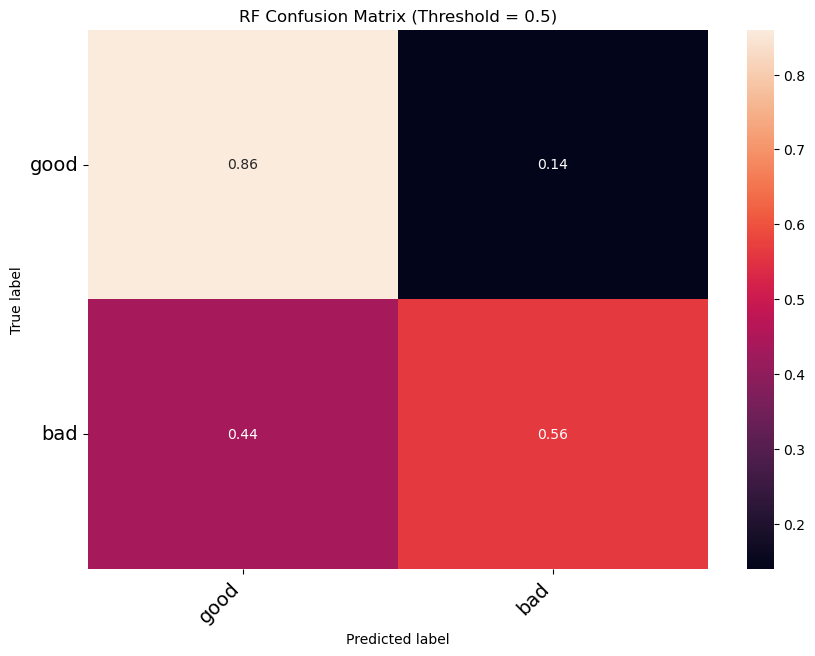

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

y_pred_rf = (y_proba_rf >= 0.5).astype(int)

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = bankloan_test_noWoE['Default'],
                    y_pred = y_pred_rf)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'RF Confusion Matrix (Threshold = 0.5)')
# Plot!
plt.show()

Looks a bit unbalanced, but otherwise ok. It's harder to predict the defaulters. Now let's see the ROC curve.

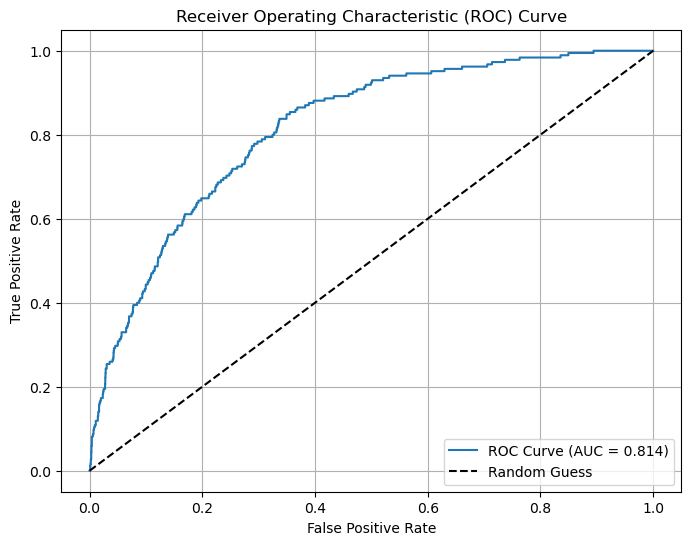

In [188]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_rf, y_proba_rf)

# Calculate the AUC
auc = roc_auc_score(y_true_rf, y_proba_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [189]:
# Generate the classification report
report = classification_report(y_true_rf, y_pred_rf, target_names=["Non-Default", "Default"], output_dict=True)

# Convert the report to a DataFrame for better display
classification_report_df = pd.DataFrame(report).transpose()

# Display the classification report
print("\nClassification Report:")
classification_report_df


Classification Report:


,precision,recall,f1-score,support
Non-Default,0.966639,0.859707,0.910043,2730.000000
Default,0.213552,0.562162,0.309524,185.000000
accuracy,0.840823,0.840823,0.840823,0.840823
macro avg,0.590096,0.710935,0.609783,2915.000000
weighted avg,0.918845,0.840823,0.871931,2915.000000


In [202]:
# Calculate performance metrics
accuracy = accuracy_score(y_true_rf, y_pred_rf)
precision_rf = precision_score(y_true_rf, y_pred_rf)
recall_rf = recall_score(y_true_rf, y_pred_rf)
f1 = f1_score(y_true_rf, y_pred_rf)
roc_auc = roc_auc_score(y_true_rf, y_proba_rf)
gini_index = 2 * roc_auc - 1

# Combine metrics into a dictionary
performance_metrics = {
    "Accuracy": accuracy,
    "Precision": precision_rf,
    "Recall": recall_rf,
    "F1-Score": f1,
    "ROC-AUC": roc_auc,

}

# Convert to a DataFrame for better display
performance_metrics_rf = pd.DataFrame([performance_metrics])

# Display the performance metrics
print("\nPerformance Metrics:")
performance_metrics_rf


Performance Metrics:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.840823,0.213552,0.562162,0.309524,0.814441


In [203]:
# Performance metrics for 2 model
pf = pd.concat([performance_metrics_lr, performance_metrics_rf], axis=0)
# Add the "Model" column with specified values
pf["Model"] = ["LR", "RF"]
pf

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Model
0,0.781818,0.181047,0.691892,0.286996,0.825600,LR
0,0.840823,0.213552,0.562162,0.309524,0.814441,RF


In [192]:
#Precision and recall for logistic model
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
##Precision and recall for logistic model
precision_rf = precision_score(y_true_rf, y_pred_rf)
recall_rf = recall_score(y_true_rf, y_pred_rf)


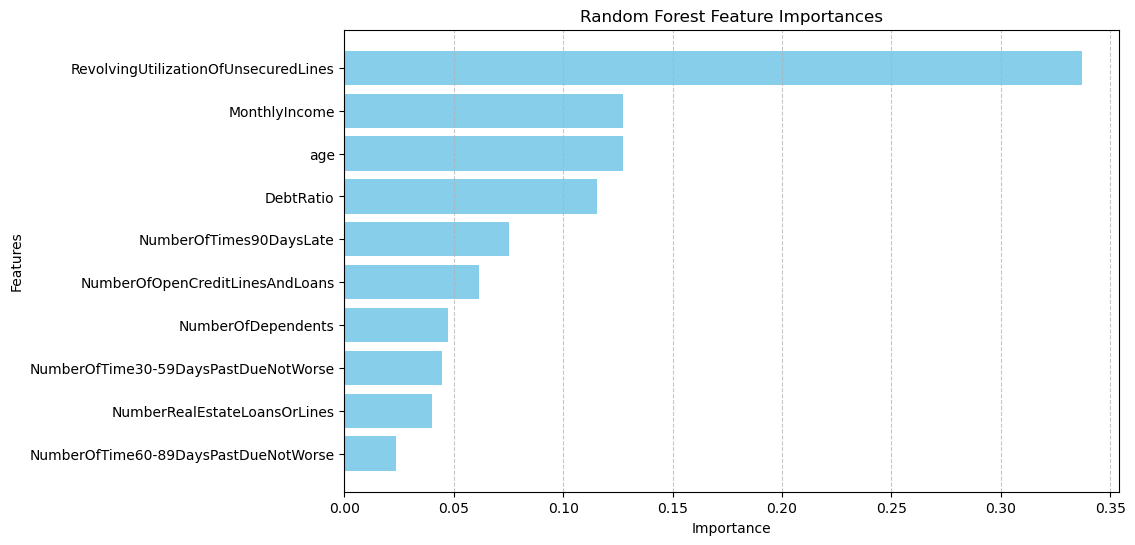

In [193]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names and their importances
features = bankloan_train_noWoE.columns[:-1]  # Replace with the actual feature names
importances = bankloan_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

Again, this is part of the ```sklearn.ensemble```

In [194]:
from sklearn.ensemble import GradientBoostingClassifier
bankloan_xg = GradientBoostingClassifier(loss='log_loss', # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost.
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=100, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=1, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=36621943, # Seed
                           max_features='sqrt', # Same as RF.
                           verbose=1,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           # presort='auto', # Whether to presort the data to speed up training. This parameter is deprecated
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [195]:
bankloan_xg.fit(bankloan_train_noWoE.iloc[:,:-1],
                bankloan_train_noWoE['Default'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3310           0.0539            0.40s
         2           1.2860           0.0480            0.34s
         3           1.2471           0.0433            0.35s
         4           1.2074           0.0271            0.36s
         5           1.1789           0.0314            0.34s
         6           1.1561           0.0280            0.34s
         7           1.1332           0.0154            0.33s
         8           1.1220           0.0295            0.33s
         9           1.0996           0.0144            0.33s
        10           1.0794           0.0156            0.32s
        20           0.9784          -0.0159            0.27s
        30           0.9291          -0.0038            0.24s
        40           0.9072           0.0165            0.20s
        50           0.8869           0.0164            0.17s
        60           0.8744           0.0361            0.13s
       

GradientBoostingClassifier(max_features='sqrt', min_impurity_decrease=0.01,
                           random_state=36621943, subsample=0.632,
                           validation_fraction=0.3, verbose=1)

The verbose option gives us the error reduction. We can see it did not converge with our requested tolerance, we might want to increase the number of trees, although with 1000 cases it makes sense this will not happen.

Let's calculate the efficiency metrics.

In [196]:
# Apply the model to the test set.
xg_pred_class_test = bankloan_xg.predict(bankloan_test_noWoE.iloc[:, :-1])
xg_probs_test = bankloan_xg.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

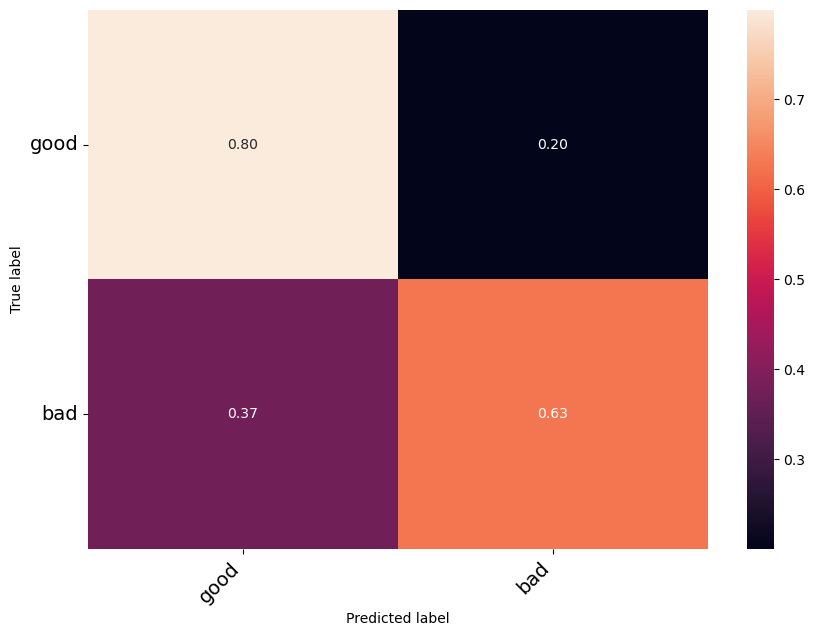

In [197]:
# Calculate confusion matrix
confusion_matrix_xg = confusion_matrix(y_true = bankloan_test_noWoE['Default'],
                    y_pred = xg_pred_class_test)

# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xg, index=['good', 'bad'], columns=['good', 'bad'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Very similar results. Now there is no chance to use sample weights sadly, so the solution is a bit more unbalanced. This is not too much of an issue though, as we can always change the cutoff point to account for the unbalance.

Let's check the ROC curve.

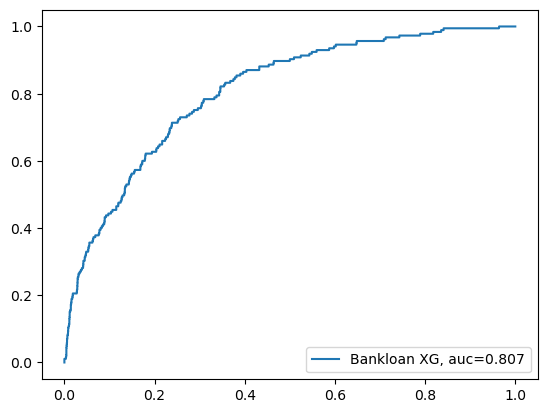

In [198]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], xg_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'],
                             y_score = xg_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan XG, auc="+str(auc))
plt.legend(loc=4)
plt.show()

We can see however the XGBoost is slightly better than the Random Forest. This is probably not statistically significant though.

## Self-Study: Plotting multiple ROC curves

The last thing we would like to do is to plot multiple ROC curves in one graph. This is fairly straightforward, we just pass  the ```plt.plot``` command each of the ROC curves. I'll do dynamically using a dictionary and a for loop.

In [199]:
# Predict probabilities of scorecard.
logreg_probs_test = bankloan_logreg.predict_proba(bankloan_test_WoE.iloc[:, 1:])

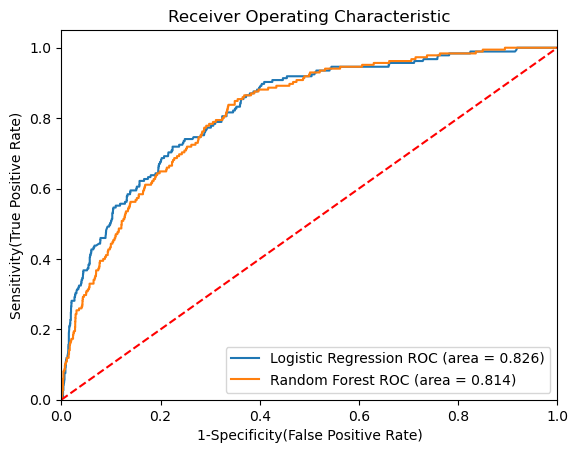

In [200]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Logistic Regression',
    'probs': logreg_probs_test[:,1],
    'dataset': bankloan_test_WoE # Added dataset for Logistic Regression
},
#{
#    'label': 'Gradient Boosting',
#    'probs': xg_probs_test[:,1],
#    'dataset': bankloan_test_noWoE # Added dataset for Gradient Boosting
#},
{
    'label': 'Random Forest',
    'probs': rf_probs_test[:,1],
    'dataset': bankloan_test_noWoE # Added dataset for Random Forest
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = m['dataset']['Default'], # Use the correct dataset for y_true
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(m['dataset']['Default'], # Use the correct dataset for roc_curve
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))



# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot!
plt.show()

I introduced several new concepts here. First, a dictionary. A dictionary is a very useful structure, which allows to have values indexed by a name. Every item will have their own values for its name, here the 'label' and 'probs'. I use this as an input for the for loop.

Second, check the part

```
label='%s ROC (area = %0.3f)' % (m['label'], auc)
```

of the plot definition. Note the ```%s``` and ```%0.3f``` in the string. This is a magic command that tells Python "this is a variable, in a certain format. Go look for it outside and match it in order". So in this case we have two:

- An ```%s``` which means 'This is a string'.
- A ```%0.3f``` which means 'This is a float (decimal), and I want it formatted using three decimals'.

Outside the string there is a ```% (m['label'], auc)```. This is matched one by one, the ```%s``` to the ```m['label']``` (the string), and the ```%0.3f``` to the ```auc```. This way I can create dynamically labels. Remember to use these tricks to simplify your life!